In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_absolute_percentage_error
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose

In [ ]:
file_path = 'Data402.csv'
data = pd.read_csv(file_path)

data['mon'] = pd.to_datetime(data['mon']).dt.to_period('M')

print(data.head())


In [ ]:
data['tariff'] = data['total_amount'] / data['total_volume']

fig, axes = plt.subplots(1, 3, figsize=(24, 6), sharex=True)

axes[0].plot(data.index, data['total_amount'], label='Сумма (total_amount)', color='blue')
axes[0].set_title('Сумма (total_amount)')
axes[0].set_xlabel('Дата')
axes[0].set_ylabel('Сумма')
axes[0].grid()
axes[0].legend()

axes[1].plot(data.index, data['total_volume'], label='Количество машин (total_volume)', color='green')
axes[1].set_title('Количество машин (total_volume)')
axes[1].set_xlabel('Дата')
axes[1].set_ylabel('Количество')
axes[1].grid()
axes[1].legend()

axes[2].plot(data.index, data['tariff'], label='Тариф (tariff)', color='orange')
axes[2].set_title('Тариф (tariff)')
axes[2].set_xlabel('Дата')
axes[2].set_ylabel('Тариф (руб/машина)')
axes[2].grid()
axes[2].legend()

plt.tight_layout()
plt.show()


In [ ]:
from IPython.display import display

display(data[['mon', 'total_volume', 'total_amount', 'tariff']].head(10))


,mon,total_volume,total_amount,tariff
0,2021-01,650887,93458765.0,143.586775
1,2021-02,720405,106341838.0,147.613964
2,2021-03,853659,126640920.0,148.350711
3,2021-04,916574,135459958.0,147.789440
4,2021-05,878094,126900575.0,144.518212
5,2021-06,991395,142698033.0,143.936608
6,2021-07,944494,135381329.0,143.337416
7,2021-08,945693,135013578.0,142.766815
8,2021-09,1009823,143918090.0,142.518134
9,2021-10,1009442,142965253.0,141.628001


### попоытаемся предсказать что справа от пунктирной линии

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


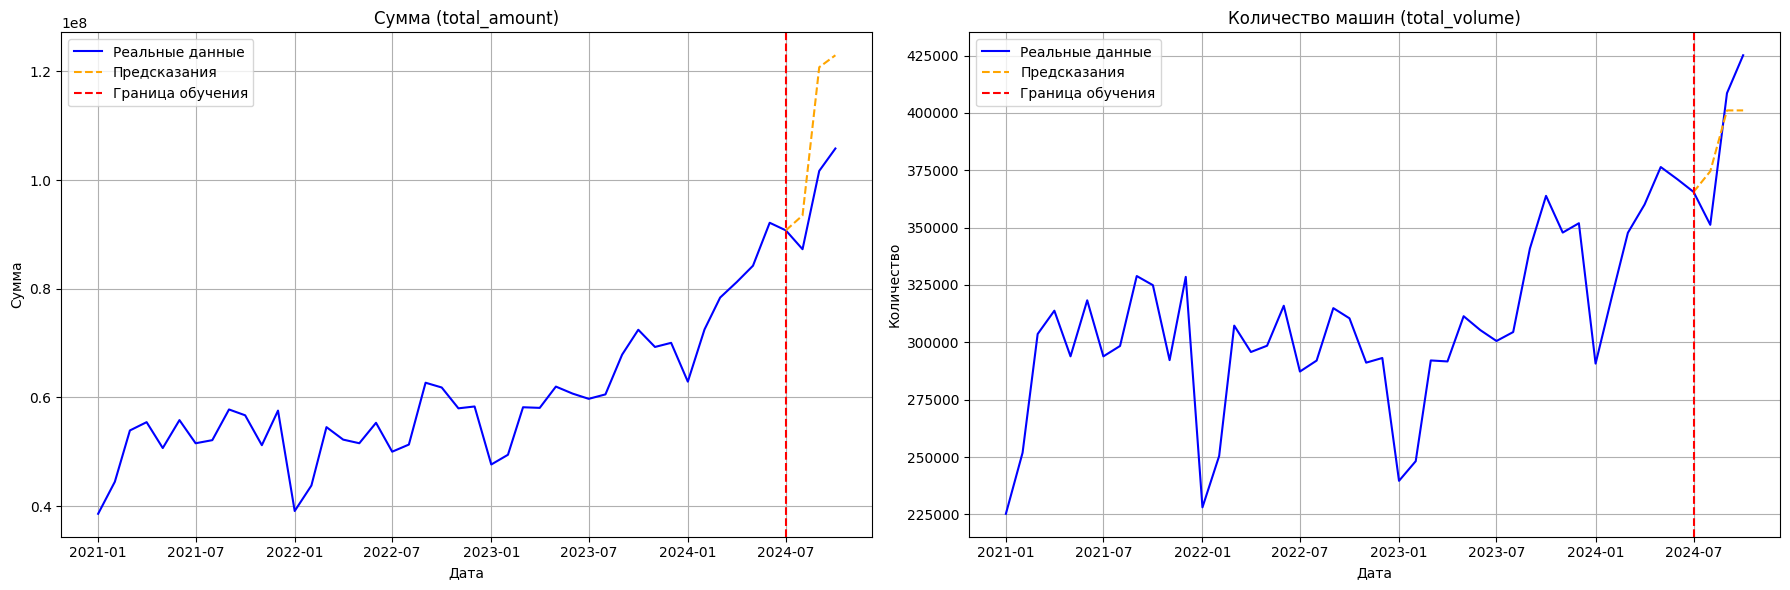

In [ ]:
data.index.freq = 'MS'

def train_and_forecast(series, start_forecast, steps=3):
    train_data = series[:start_forecast]
    model = ExponentialSmoothing(
        train_data,
        seasonal='add',         # Сезонность: аддитивная
        seasonal_periods=12,    # Период сезонности: 12 месяцев
        trend='add',            # Тренд: линейный
        use_boxcox=True         # Логарифмическая трансформация
    )
    fitted_model = model.fit(optimized=True)
    forecast_index = pd.date_range(start=start_forecast, periods=steps + 1, freq='MS')[1:]
    forecast = pd.Series(fitted_model.forecast(steps), index=forecast_index)

    last_point = pd.Series({train_data.index[-1]: train_data.iloc[-1]})
    forecast = pd.concat([last_point, forecast])

    return train_data, forecast

train_amount, forecast_amount = train_and_forecast(data['total_amount'], '2024-07-01')

train_volume, forecast_volume = train_and_forecast(data['total_volume'], '2024-07-01')

fig, axes = plt.subplots(1, 2, figsize=(18, 6), sharex=True)

axes[0].plot(data.index, data['total_amount'], label='Реальные данные', color='blue')
axes[0].plot(forecast_amount.index, forecast_amount, label='Предсказания', color='orange', linestyle='--')
axes[0].axvline(pd.to_datetime('2024-07-01'), color='red', linestyle='--', label='Граница обучения')
axes[0].set_title('Сумма (total_amount)')
axes[0].set_xlabel('Дата')
axes[0].set_ylabel('Сумма')
axes[0].legend()
axes[0].grid()

axes[1].plot(data.index, data['total_volume'], label='Реальные данные', color='blue')
axes[1].plot(forecast_volume.index, forecast_volume, label='Предсказания', color='orange', linestyle='--')
axes[1].axvline(pd.to_datetime('2024-07-01'), color='red', linestyle='--', label='Граница обучения')
axes[1].set_title('Количество машин (total_volume)')
axes[1].set_xlabel('Дата')
axes[1].set_ylabel('Количество')
axes[1].legend()
axes[1].grid()

plt.tight_layout()
plt.show()


Понимаем, что предсказывать нужно только МАШИНЫ

Теперь давайте рассмотрим Route 404

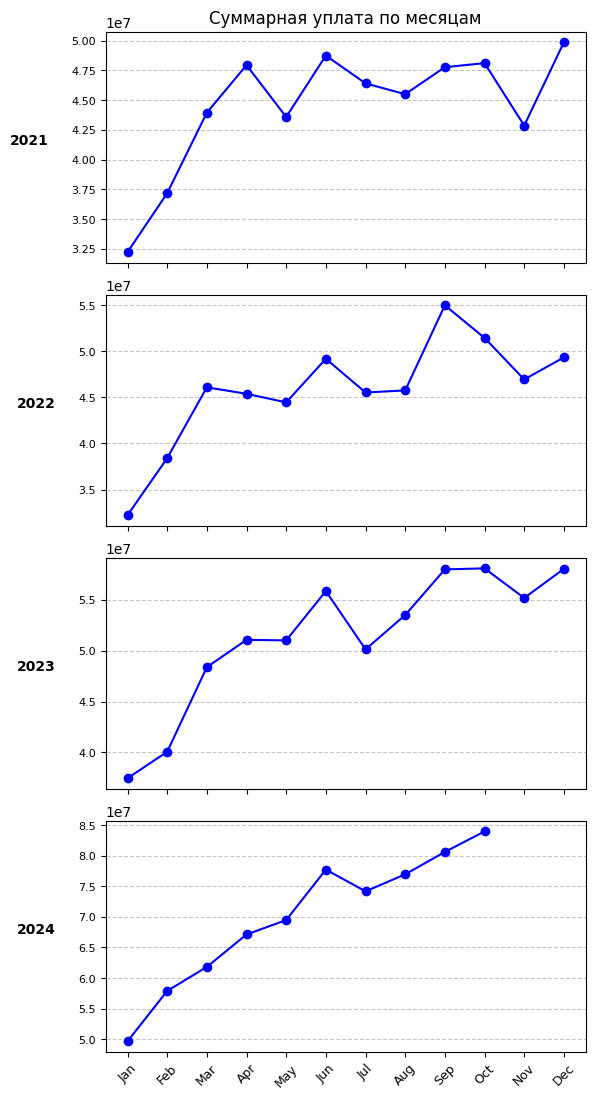

In [ ]:
file_path = 'Data403.csv'
data = pd.read_csv(file_path)

data['mon'] = pd.to_datetime(data['mon'])
data.set_index('mon', inplace=True)

years = [2021, 2022, 2023, 2024]
months = pd.date_range("2021-01", "2021-12", freq="MS").strftime("%b")

fig, axes = plt.subplots(len(years), 1, figsize=(6, 12), sharex=True)

for i, year in enumerate(years):
    year_data = data[data.index.year == year].reindex(pd.date_range(f"{year}-01", f"{year}-12", freq="MS"))
    axes[i].plot(months, year_data['total_amount'], marker='o', linestyle='-', color='blue')
    axes[i].set_ylabel(f'{year}', rotation=0, labelpad=30, fontsize=10, weight='bold', ha='center')
    axes[i].tick_params(axis='y', which='both', labelsize=8)
    axes[i].grid(axis='y', linestyle='--', alpha=0.7)
    if i == 0:
        axes[i].set_title('Суммарная уплата по месяцам', fontsize=12)

axes[-1].set_xticks(range(12))
axes[-1].set_xticklabels(months, rotation=45, fontsize=9)

plt.tight_layout()
plt.subplots_adjust(left=0.15, right=0.95, top=0.95, bottom=0.1)
plt.show()


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


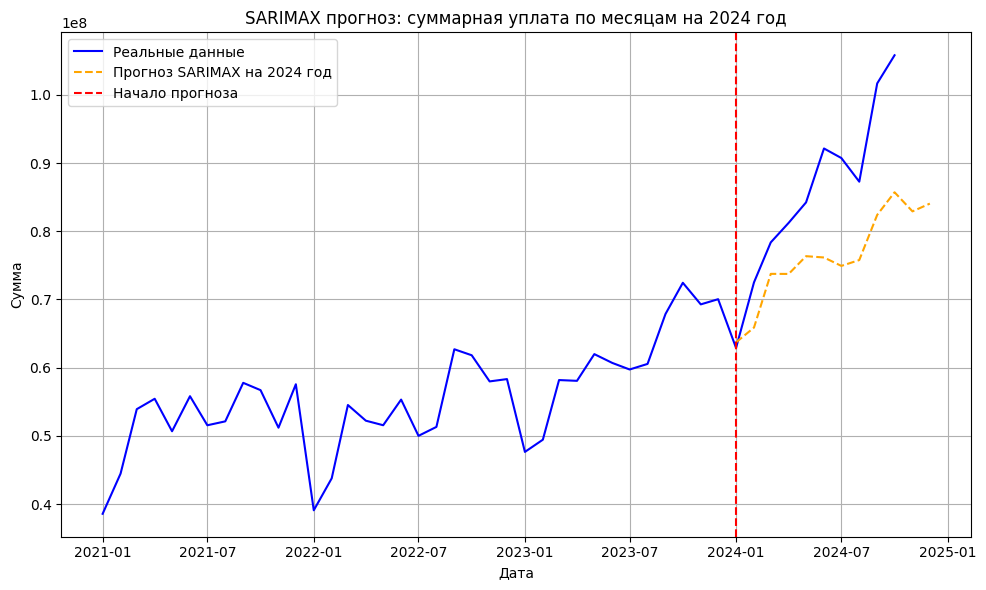

In [ ]:

file_path = 'Data404.csv'
data = pd.read_csv(file_path)

data['mon'] = pd.to_datetime(data['mon'])
data.set_index('mon', inplace=True)

train_data = data['2021':'2023']
forecast_period = pd.date_range('2024-01-01', '2024-12-01', freq='MS')
# Настройка модели SARIMAX
model = SARIMAX(train_data['total_amount'], order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
result = model.fit(disp=False)

forecast = result.forecast(steps=12)
forecast.index = forecast_period

# Построение графиков
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(data.index, data['total_amount'], label='Реальные данные', color='blue')
ax.plot(forecast.index, forecast, label='Прогноз SARIMAX на 2024 год', color='orange', linestyle='--')
ax.axvline(pd.to_datetime('2024-01-01'), color='red', linestyle='--', label='Начало прогноза')
ax.set_title('SARIMAX прогноз: суммарная уплата по месяцам на 2024 год')
ax.set_xlabel('Дата')
ax.set_ylabel('Сумма')
ax.legend()
ax.grid()

plt.tight_layout()
plt.show()


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


MAPE на прогнозных данных (2024-02 по 2024-10): 2.48%


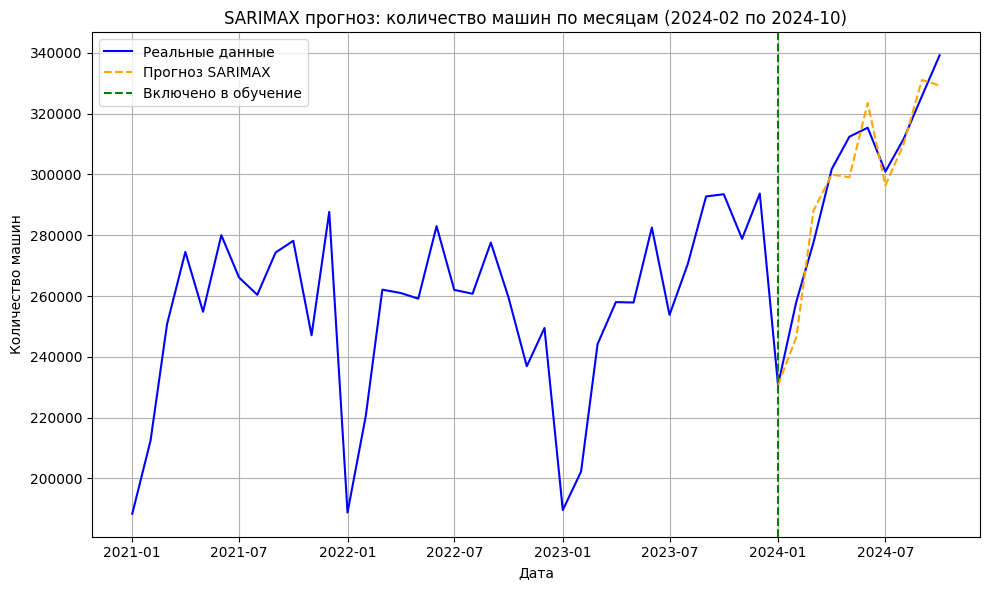

In [ ]:

file_path = 'Data403.csv'
data = pd.read_csv(file_path)

data['mon'] = pd.to_datetime(data['mon'])
data.set_index('mon', inplace=True)

data = data.asfreq('MS')

data['total_volume'] = data['total_volume'].interpolate()

train_data = data['2021':'2024-01']

forecast_period = pd.date_range('2024-02-01', '2024-10-01', freq='MS')

model = SARIMAX(train_data['total_volume'], order=(1, 1, 0), seasonal_order=(1, 1, 1, 12))
result = model.fit(disp=False)

forecast = result.get_forecast(steps=9).predicted_mean
forecast.index = forecast_period

actual_values = data.loc['2024-02':'2024-10', 'total_volume']
mape = mean_absolute_percentage_error(actual_values, forecast) * 100

fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(data.index, data['total_volume'], label='Реальные данные', color='blue')

last_real_value = data['total_volume'].loc['2024-01']
forecast_with_smooth = pd.concat([
    pd.Series(last_real_value, index=[pd.Timestamp('2024-01-01')]),
    forecast
])
ax.plot(forecast_with_smooth.index, forecast_with_smooth, label='Прогноз SARIMAX', color='orange', linestyle='--')

ax.axvline(pd.to_datetime('2024-01-01'), color='green', linestyle='--', label='Включено в обучение')

ax.set_title('SARIMAX прогноз: количество машин по месяцам (2024-02 по 2024-10)')
ax.set_xlabel('Дата')
ax.set_ylabel('Количество машин')
ax.legend()
ax.grid()



print(f"MAPE на прогнозных данных (2024-02 по 2024-10): {mape:.2f}%")

plt.tight_layout()
plt.show()


seasonal_order=(P, D, Q, s)
Эти параметры отвечают за сезонность в модели:

P (Seasonal AR): сезонный порядок авторегрессии.

D (Seasonal differencing): порядок сезонного дифференцирования (для устранения сезонных трендов).

Q (Seasonal MA): сезонный порядок скользящей средней.

s: период сезонности (например, 12 для годовой сезонности в ежемесячных данных).

Прекрасные результаты по MAPE. Посмотрим декомпозицию

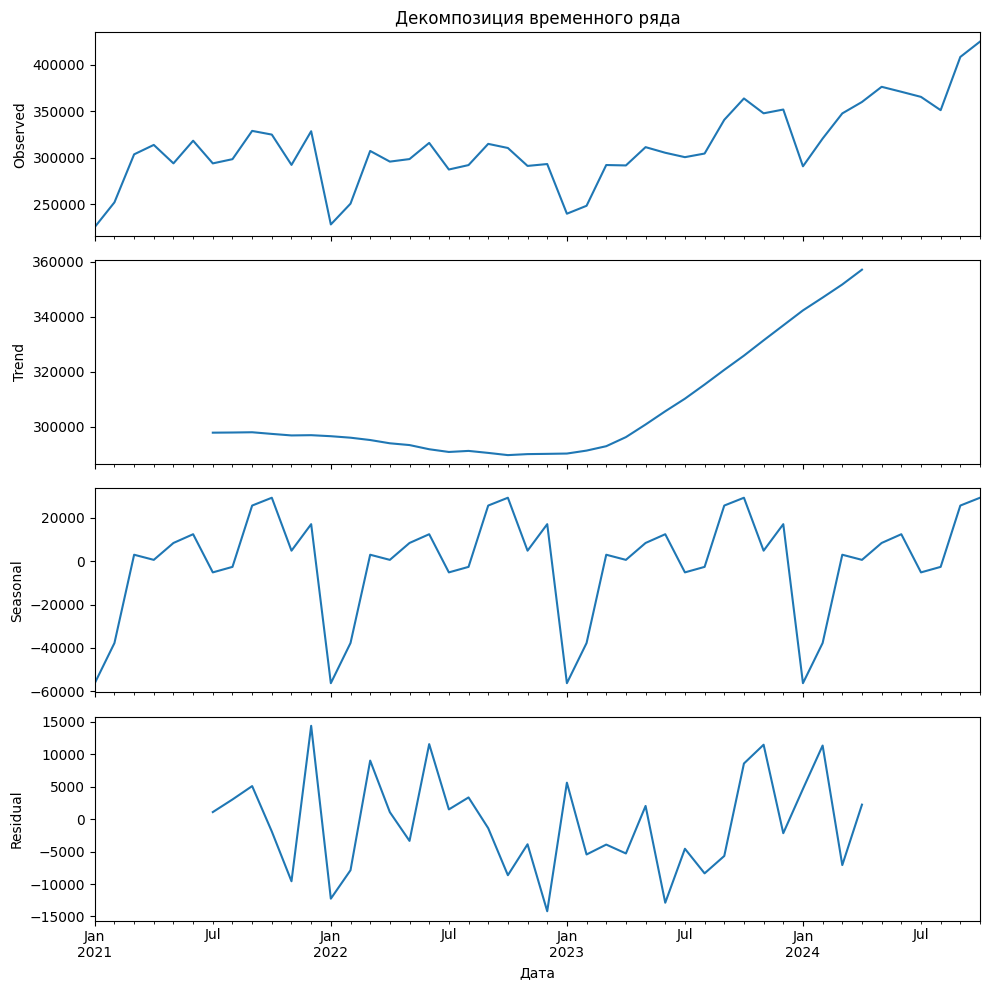

In [ ]:

file_path = 'Data404.csv'
data = pd.read_csv(file_path)
data['mon'] = pd.to_datetime(data['mon'])
data.set_index('mon', inplace=True)

data = data.asfreq('MS')

data['total_volume'] = data['total_volume'].interpolate()

train_data = data['2021':'2024-01']

forecast_period = pd.date_range('2024-02-01', '2024-10-01', freq='MS')

result_decompose = seasonal_decompose(data['total_volume'], model='additive')
fig_decompose, axes = plt.subplots(4, 1, figsize=(10, 10), sharex=True)

result_decompose.observed.plot(ax=axes[0], legend=False)
axes[0].set_ylabel('Observed')
axes[0].set_title('Декомпозиция временного ряда')

result_decompose.trend.plot(ax=axes[1], legend=False)
axes[1].set_ylabel('Trend')

result_decompose.seasonal.plot(ax=axes[2], legend=False)
axes[2].set_ylabel('Seasonal')

result_decompose.resid.plot(ax=axes[3], legend=False)
axes[3].set_ylabel('Residual')
axes[3].set_xlabel('Дата')

plt.tight_layout()
plt.show()


Сделаем с зависимостью от тарифа

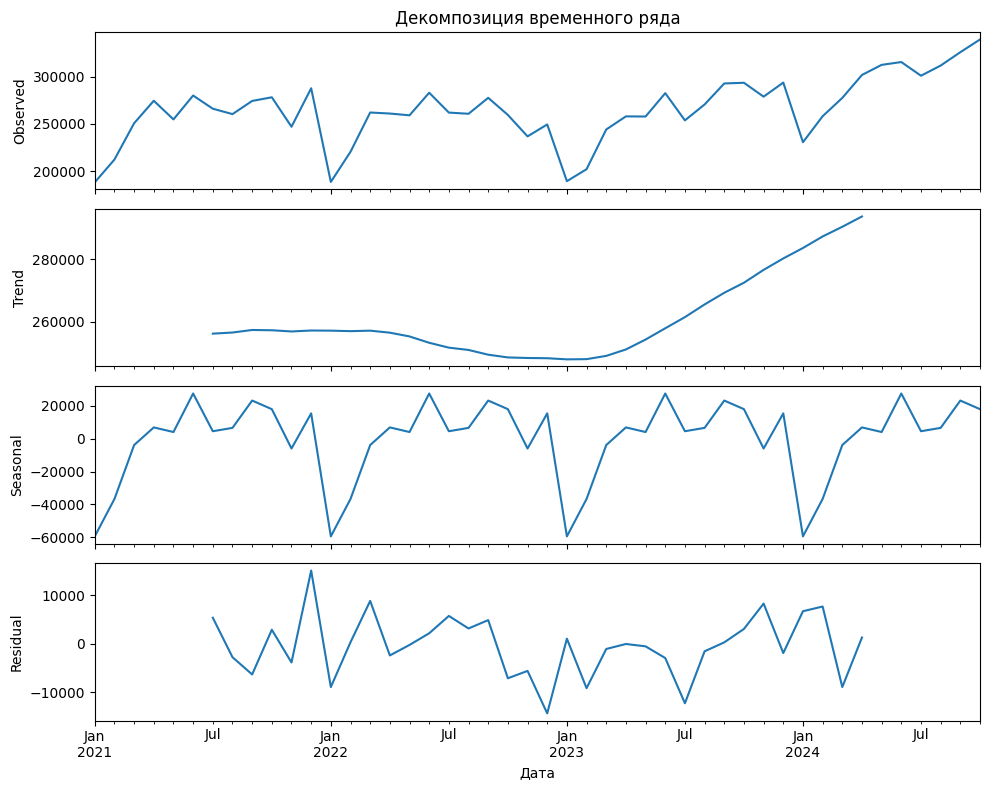

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


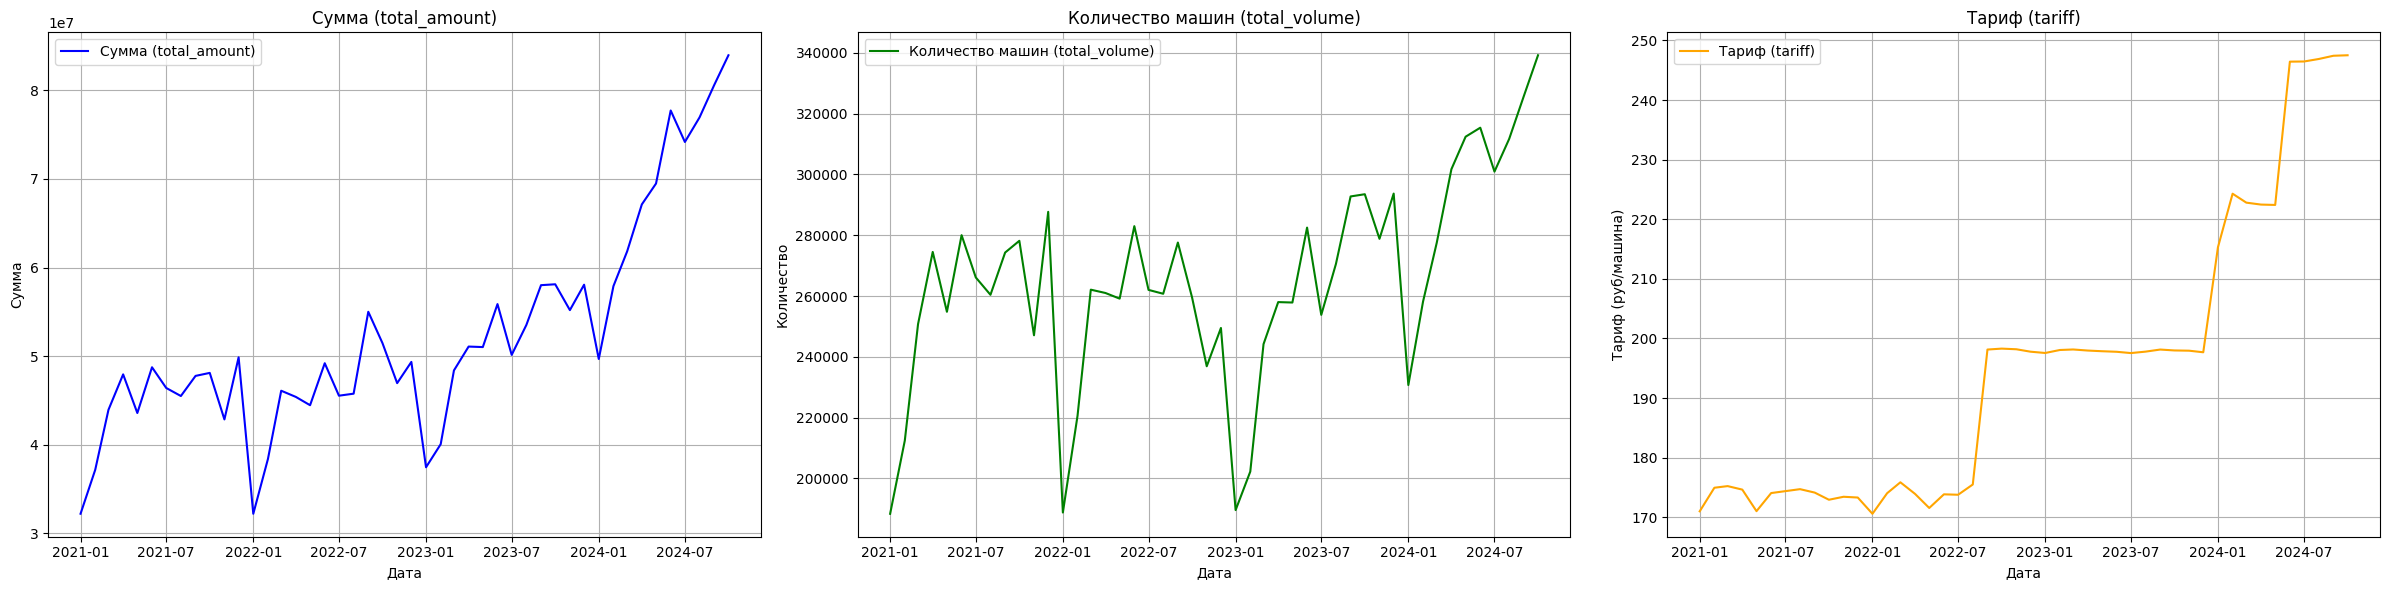

MAPE на прогнозных данных с учётом тарифа (2024-02 по 2024-10): 11.77%


In [ ]:

file_path = 'Data403.csv'
data = pd.read_csv(file_path)

data['mon'] = pd.to_datetime(data['mon'])
data.set_index('mon', inplace=True)

data = data.asfreq('MS')

data['total_volume'] = data['total_volume'].interpolate()
data['tariff'] = data['total_amount'] / data['total_volume']

train_data = data['2021':'2024-01']
forecast_period = pd.date_range('2024-02-01', '2024-10-01', freq='MS')

result_decompose = seasonal_decompose(data['total_volume'], model='additive')
fig_decompose, axes = plt.subplots(4, 1, figsize=(10, 8), sharex=True)

result_decompose.observed.plot(ax=axes[0], legend=False)
axes[0].set_ylabel('Observed')
axes[0].set_title('Декомпозиция временного ряда')

result_decompose.trend.plot(ax=axes[1], legend=False)
axes[1].set_ylabel('Trend')

result_decompose.seasonal.plot(ax=axes[2], legend=False)
axes[2].set_ylabel('Seasonal')

result_decompose.resid.plot(ax=axes[3], legend=False)
axes[3].set_ylabel('Residual')
axes[3].set_xlabel('Дата')

plt.tight_layout()
plt.show()

tariff_adjusted_volume = train_data['total_volume'] / train_data['tariff']
model = SARIMAX(tariff_adjusted_volume, order=(1, 1, 0), seasonal_order=(0, 1, 1, 12))
result = model.fit(disp=False)

forecast = result.get_forecast(steps=9).predicted_mean
forecast.index = forecast_period

forecast = forecast * data['tariff'].loc['              ':'2024-10'].mean()

actual_values = data.loc['2024-02':'2024-10', 'total_volume']
mape = mean_absolute_percentage_error(actual_values, forecast) * 100

fig, axes = plt.subplots(1, 3, figsize=(24, 6), sharex=True)

axes[0].plot(data.index, data['total_amount'], label='Сумма (total_amount)', color='blue')
axes[0].set_title('Сумма (total_amount)')
axes[0].set_xlabel('Дата')
axes[0].set_ylabel('Сумма')
axes[0].grid()
axes[0].legend()

axes[1].plot(data.index, data['total_volume'], label='Количество машин (total_volume)', color='green')
axes[1].set_title('Количество машин (total_volume)')
axes[1].set_xlabel('Дата')
axes[1].set_ylabel('Количество')
axes[1].grid()
axes[1].legend()

axes[2].plot(data.index, data['tariff'], label='Тариф (tariff)', color='orange')
axes[2].set_title('Тариф (tariff)')
axes[2].set_xlabel('Дата')
axes[2].set_ylabel('Тариф (руб/машина)')
axes[2].grid()
axes[2].legend()

plt.tight_layout()
plt.show()

print(f"MAPE на прогнозных данных с учётом тарифа (2024-02 по 2024-10): {mape:.2f}%")


            total_volume  total_amount
hour                                  
2021-01-01          1114        147541
2021-01-02          2326        342394
2021-01-03          2811        412670
2021-01-04          3398        504238
2021-01-05          3455        512440


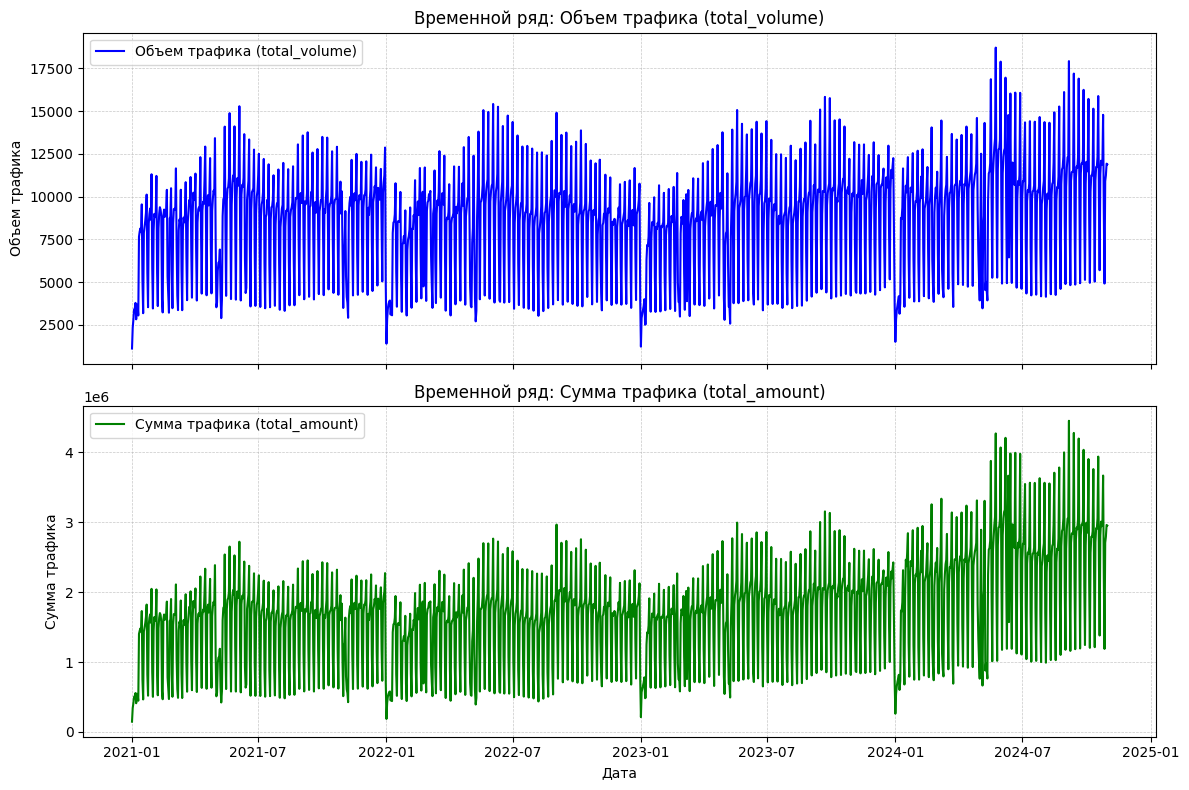

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

file_path = 'Data_hour403.csv'
data = pd.read_csv(file_path)

data['hour'] = pd.to_datetime(data['hour'])
data.set_index('hour', inplace=True)

data = data.asfreq('D')  # Дневная частота

print(data.head())

fig, axes = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

axes[0].plot(data.index, data['total_volume'], label='Объем трафика (total_volume)', color='blue')
axes[0].set_title('Временной ряд: Объем трафика (total_volume)')
axes[0].set_ylabel('Объем трафика')
axes[0].grid(which='major', linestyle='--', linewidth=0.5, alpha=0.7)
axes[0].legend()

axes[1].plot(data.index, data['total_amount'], label='Сумма трафика (total_amount)', color='green')
axes[1].set_title('Временной ряд: Сумма трафика (total_amount)')
axes[1].set_xlabel('Дата')
axes[1].set_ylabel('Сумма трафика')
axes[1].grid(which='major', linestyle='--', linewidth=0.5, alpha=0.7)
axes[1].legend()

plt.tight_layout()
plt.show()

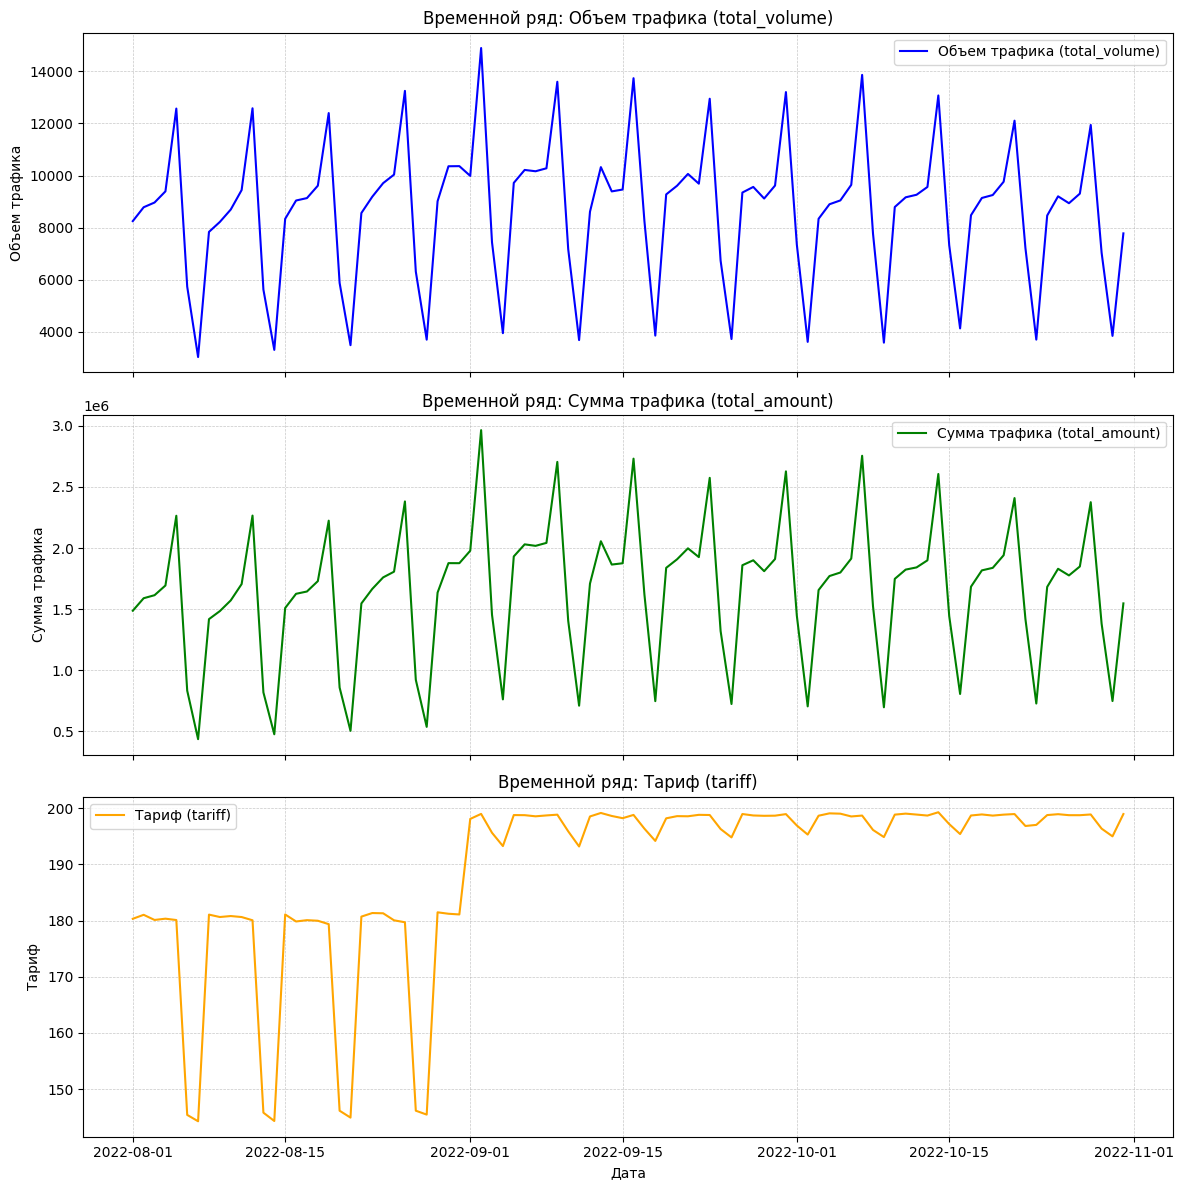

In [4]:
import pandas as pd
import matplotlib.pyplot as plt

file_path = 'Data_hour403.csv'
data = pd.read_csv(file_path)

data['hour'] = pd.to_datetime(data['hour'])
data.set_index('hour', inplace=True)

data = data.asfreq('D')

data['tariff'] = data['total_amount'] / data['total_volume']

filtered_data = data['2022-08-01':'2022-10-31']

fig, axes = plt.subplots(3, 1, figsize=(12, 12), sharex=True)

axes[0].plot(filtered_data.index, filtered_data['total_volume'], label='Объем трафика (total_volume)', color='blue')
axes[0].set_title('Временной ряд: Объем трафика (total_volume)')
axes[0].set_ylabel('Объем трафика')
axes[0].grid(which='major', linestyle='--', linewidth=0.5, alpha=0.7)
axes[0].legend()

axes[1].plot(filtered_data.index, filtered_data['total_amount'], label='Сумма трафика (total_amount)', color='green')
axes[1].set_title('Временной ряд: Сумма трафика (total_amount)')
axes[1].set_ylabel('Сумма трафика')
axes[1].grid(which='major', linestyle='--', linewidth=0.5, alpha=0.7)
axes[1].legend()

axes[2].plot(filtered_data.index, filtered_data['tariff'], label='Тариф (tariff)', color='orange')
axes[2].set_title('Временной ряд: Тариф (tariff)')
axes[2].set_xlabel('Дата')
axes[2].set_ylabel('Тариф')
axes[2].grid(which='major', linestyle='--', linewidth=0.5, alpha=0.7)
axes[2].legend()

plt.tight_layout()
plt.show()

видим что 2022-09-01 тарифф поменялся

Средний тариф до изменения: 133.66
Средний тариф после изменения: 176.49
Изменение тарифа: 32.05%
Средний объем до изменения: 347.57
Средний объем после изменения: 374.32
Изменение объема: 7.70%


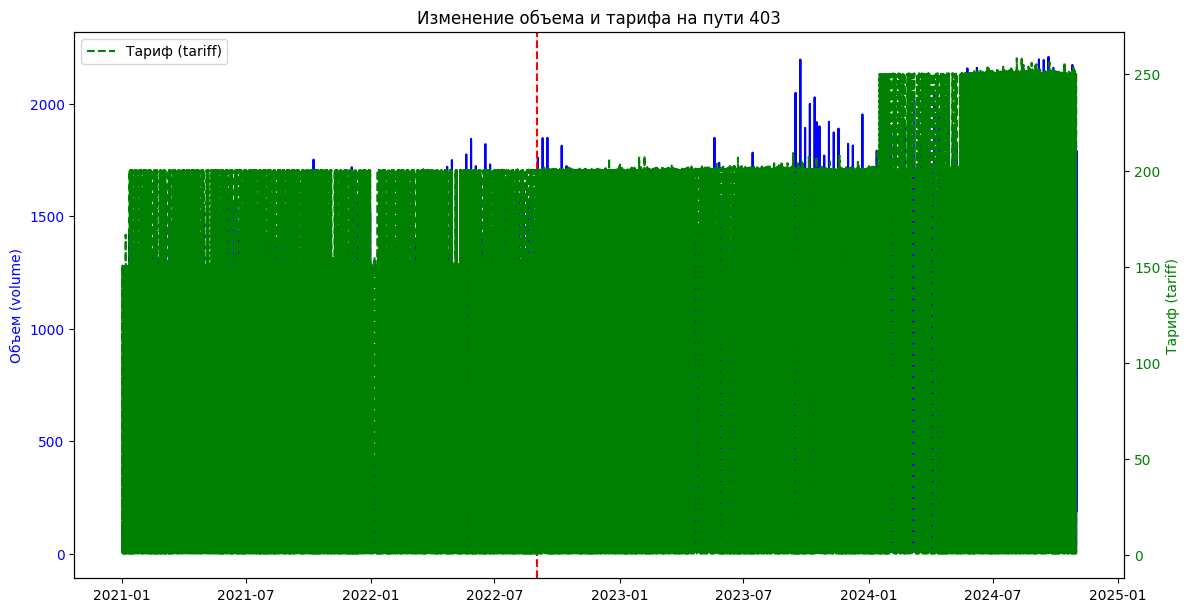

In [7]:
import pandas as pd
import matplotlib.pyplot as plt

file_path = 'Data_hourss403.csv'
data = pd.read_csv(file_path)

data['start_dt_with_hour'] = pd.to_datetime(data['start_dt_with_hour'])
data['end_dt_with_hour'] = pd.to_datetime(data['end_dt_with_hour'])
data.set_index('start_dt_with_hour', inplace=True)

route_data = data[data['route_id'] == 403].copy()

route_data['volume'] = pd.to_numeric(route_data['volume'], errors='coerce')
route_data['amount'] = pd.to_numeric(route_data['amount'], errors='coerce')
route_data['tariff'] = route_data['amount'] / route_data['volume']

split_date = pd.Timestamp('2022-09-01 00:00:00')
before_tariff_change = route_data[:split_date]
after_tariff_change = route_data[split_date:]

mean_before = before_tariff_change['volume'].mean()
mean_after = after_tariff_change['volume'].mean()
tariff_before = before_tariff_change['tariff'].mean()
tariff_after = after_tariff_change['tariff'].mean()

tariff_change = ((tariff_after - tariff_before) / tariff_before) * 100
volume_change = ((mean_after - mean_before) / mean_before) * 100

print(f"Средний тариф до изменения: {tariff_before:.2f}")jn
print(f"Средний тариф после изменения: {tariff_after:.2f}")
print(f"Изменение тарифа: {tariff_change:.2f}%")
print(f"Средний объем до изменения: {mean_before:.2f}")
print(f"Средний объем после изменения: {mean_after:.2f}")
print(f"Изменение объема: {volume_change:.2f}%")

fig, ax1 = plt.subplots(figsize=(12, 6))

ax1.plot(route_data.index, route_data['volume'], label='Объем (volume)', color='blue')
ax1.axvline(split_date, color='red', linestyle='--', label='Изменение тарифа')
ax1.set_ylabel('Объем (volume)', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

ax2 = ax1.twinx()
ax2.plot(route_data.index, route_data['tariff'], label='Тариф (tariff)', color='green', linestyle='--')
ax2.set_ylabel('Тариф (tariff)', color='green')
ax2.tick_params(axis='y', labelcolor='green')

fig.tight_layout()
plt.title('Изменение объема и тарифа на пути 403')
plt.legend()
plt.show()